In [5]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

__author__ = 'Song Huang'
__email__ = 'shuang89@ucsc.edu'
__version__ = '170505A'

from __future__ import (print_function, division, absolute_import)

import os
import sys
import math
import glob
import copy
import warnings
import subprocess

import numpy as np
#import seaborn as sns
#sns.set(color_codes=True, style="darkgrid")

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#mpl.style.use('classic')
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

from astropy.io import fits
from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar

import hsc_massive
from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    smhm, \
    plotting

#envir = s16a_path.set_env(version='astro4')
envir = s16a_path.set_env(version='kungpao')

ORG = plotting.ORG
BLK = plotting.BLK
BLU = plotting.BLU
GRN = plotting.GRN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from kungpao.isophote.ellipse import Ellipse
from kungpao.isophote.ellipse import Centerer
from kungpao.isophote.ellipse import Geometry
from kungpao.isophote.ellipse.model import build_model

In [150]:
import sep

from astropy.visualization import ZScaleInterval, PercentileInterval, AsymmetricPercentileInterval

from scipy.interpolate import LSQUnivariateSpline

In [37]:
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = plt.get_cmap('tab20')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

# Load Data

In [268]:
gal_img = fits.open('redadd_529_HSC-I_full_img.fits')[0].data
gal_bad = fits.open('redadd_529_HSC-I_full_bad.fits')[0].data
gal_sig = fits.open('redadd_529_HSC-I_full_sig.fits')[0].data

In [269]:
gal_img_swap = gal_img.byteswap().newbyteorder()
gal_sig_swap = gal_sig.byteswap().newbyteorder()
gal_bad_swap = gal_bad.byteswap().newbyteorder()

In [270]:
hsc_pixel_scale = 0.176 # arcsec/ pixel
hsc_zeropoint = 27.0    # mag

print("# 10 arcsecs == %d pixels" % (10.0 / hsc_pixel_scale))

print("# 0.01/pixel == %6.3f mag/arcsec^2" % (
    -2.5 * np.log10(0.01 / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)
     )

# 10 arcsecs == 56 pixels
# 0.01/pixel == 28.228 mag/arcsec^2


# Initial Test

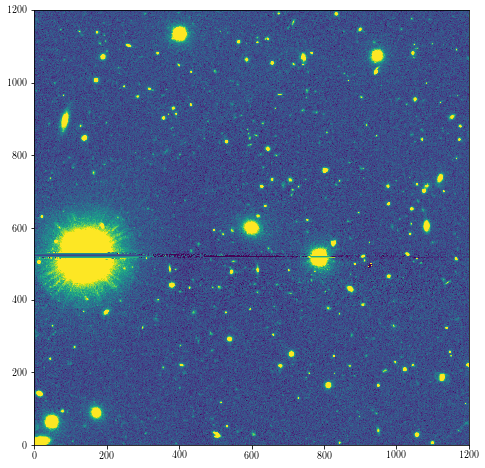

In [271]:
plt.figure(figsize=(8, 8))

gal_img_zscale = np.arcsinh(gal_img)

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(gal_img_zscale)

plt.imshow(gal_img_zscale, origin='lower', cmap=IMG_CMAP,
           vmin=zmin, vmax=zmax)

# Detect 455 objects


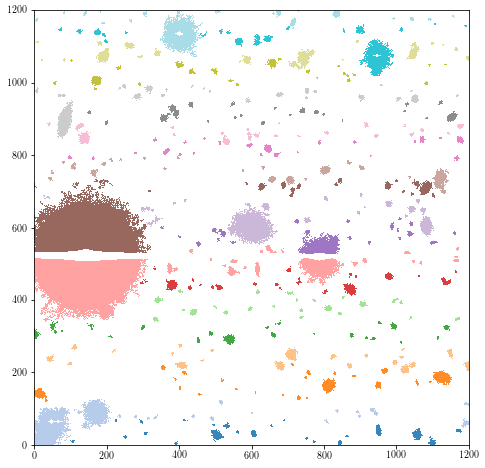

In [304]:
objects, seg = sep.extract(gal_img_swap, 2.0,
                           err=gal_sig_swap, mask=gal_bad_swap,
                           minarea=20, 
                           deblend_nthresh=24, deblend_cont=0.005,
                           clean=True, clean_param=1.0,
                           segmentation_map=True)

seg_mask = ((seg > 0) | 
            (gal_bad > 0))

print("# Detect %d objects" % len(objects))

plt.figure(figsize=(8, 8))

plt.imshow(seg, origin='lower', cmap=SEG_CMAP, 
           vmin=1, alpha=0.9)

# Mean Sky / RMS Sky =   -0.00159 /    0.05521


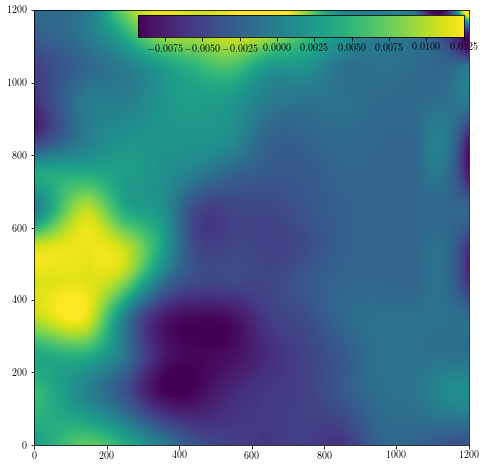

In [305]:
bkg = sep.Background(gal_img_swap, 
                     mask=seg_mask, maskthresh=0,
                     bw=100, bh=100, 
                     fw=5, fh=5)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg.globalback, bkg.globalrms))


fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

sky_zscale = np.arcsinh(bkg.back())

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(sky_zscale)

plt.imshow(sky_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

ax_cbar = inset_axes(ax1, width="75%", height="5%", loc=1) 
plt.colorbar(cax=ax_cbar, orientation='horizontal')

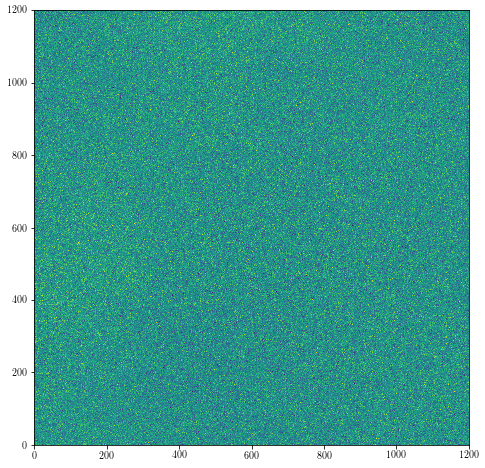

In [306]:
sky_noise_add = np.random.normal(loc=bkg.back(), 
                                 scale=bkg.rms(), 
                                 size=gal_img.shape)

plt.figure(figsize=(8, 8))

sky_noise_zscale = np.arcsinh(sky_noise_add)

zmin, zmax = ZScaleInterval(contrast=0.35).get_limits(sky_noise_zscale)

plt.imshow(sky_noise_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

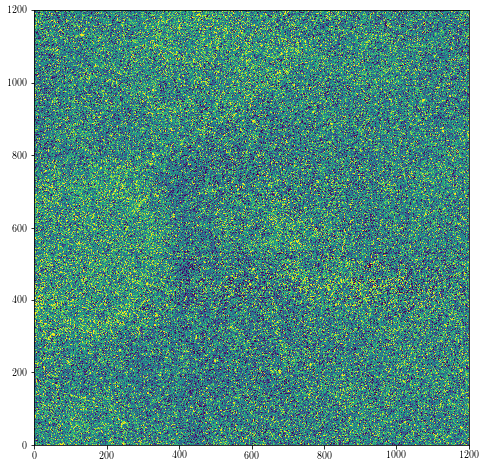

In [307]:
img_noise_replace = copy.deepcopy(gal_img)
img_noise_replace[seg_mask] = sky_noise_add[seg_mask]

plt.figure(figsize=(8, 8))

img_noise_zscale = np.arcsinh(img_noise_replace)

zmin, zmax = ZScaleInterval(contrast=0.8).get_limits(img_noise_zscale)

plt.imshow(img_noise_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

# Mean Sky / RMS Sky =   -0.00152 /    0.05504


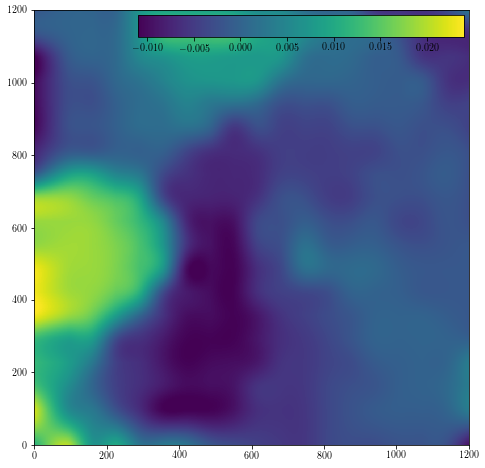

In [308]:
bkg_new = sep.Background(img_noise_replace.byteswap().newbyteorder(), 
                         mask=seg_mask, maskthresh=0,
                         bw=65, bh=65, 
                         fw=4, fh=4)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_new.globalback, bkg_new.globalrms))


fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

sky_new_zscale = np.arcsinh(bkg_new.back())

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(sky_new_zscale)

plt.imshow(sky_new_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

ax_cbar = inset_axes(ax1, width="75%", height="5%", loc=1) 
plt.colorbar(cax=ax_cbar, orientation='horizontal')

# Detect 637 objects on the noise-replaced image


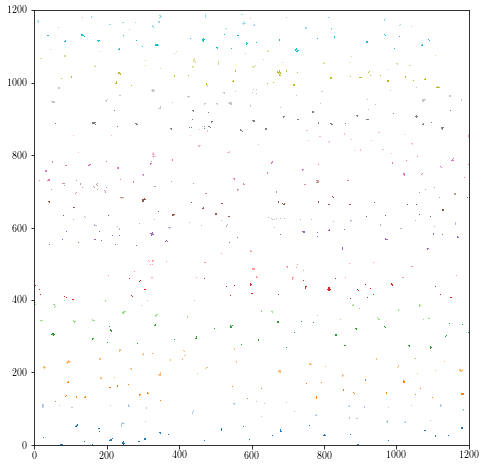

In [309]:
objects_hot, seg_hot = sep.extract(img_noise_replace.byteswap().newbyteorder(), 2.5,
                                   err=gal_sig_swap,
                                   minarea=5, 
                                   deblend_nthresh=24, deblend_cont=0.003,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

seg_mask_hot = seg_hot > 0

print("# Detect %d objects on the noise-replaced image" % len(objects_hot))

plt.figure(figsize=(8, 8))

plt.imshow(seg_hot, origin='lower', cmap=SEG_CMAP, 
           vmin=1)

In [310]:
def seg_remove_cen_obj(seg):
    """
    Remove the central object from the segmentation.
    """
    seg_copy = copy.deepcopy(seg)
    seg_copy[seg == seg[int(seg.shape[0] / 2L), int(seg.shape[1] / 2L)]] = 0
    
    return seg_copy

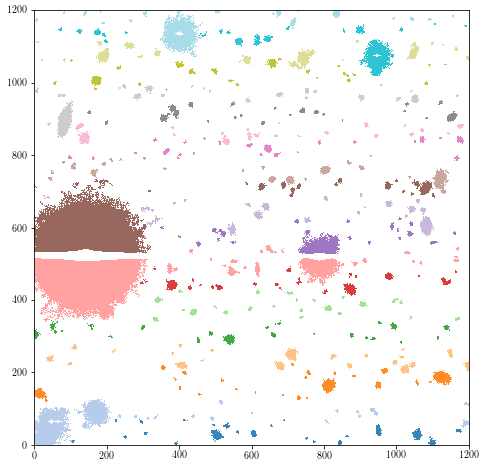

In [311]:
seg_nocen = seg_remove_cen_obj(seg)

plt.figure(figsize=(8, 8))

plt.imshow(seg_nocen, origin='lower', cmap=SEG_CMAP, 
           vmin=1, alpha=0.9)

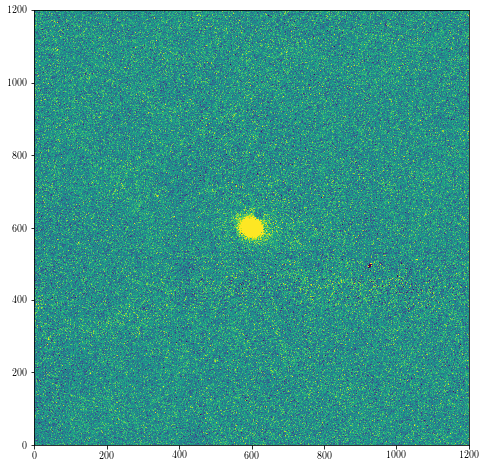

In [312]:
seg_mask_nocen = ((seg_nocen > 0) | 
                  (gal_bad > 0))

img_noise_nocen = copy.deepcopy(gal_img)
img_noise_nocen[seg_mask_nocen] = sky_noise_add[seg_mask_nocen]

img_noise_nocen[seg_mask_hot] = sky_noise_add[seg_mask_hot]

plt.figure(figsize=(8, 8))

img_noise_nocen_zscale = np.arcsinh(img_noise_nocen - bkg_new.back())

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(img_noise_nocen_zscale)

plt.imshow(img_noise_nocen_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

## Check the differences in profile

In [313]:
obj1_geom = Geometry(600.0, 600.0, 4., 0.05, 10./180.*np.pi)

obj1_nomsk_ellip = Ellipse(gal_img, geometry=obj1_geom)

obj1_clean_ellip = Ellipse((img_noise_nocen - bkg_new.back()), geometry=obj1_geom)

gal_img_msk = copy.deepcopy(gal_img - bkg_new.back())
gal_img_msk[seg_mask_nocen] = np.nan

obj1_bgmsk_ellip = Ellipse(gal_img_msk, geometry=obj1_geom)

Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0


In [314]:
obj1_nomsk_iso = obj1_nomsk_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=2, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False, verbose=False)

obj1_bgmsk_iso = obj1_bgmsk_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=2, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False, verbose=False)

obj1_clean_iso = obj1_clean_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=2, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False, verbose=False)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


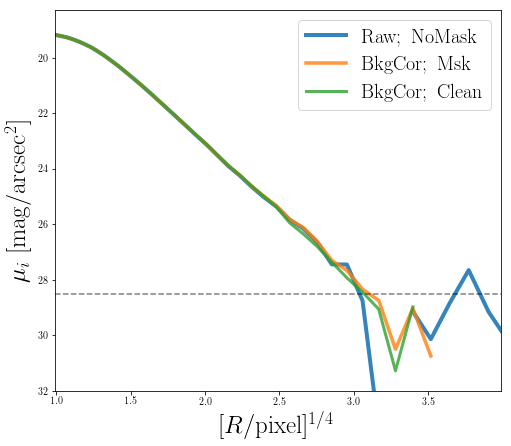

In [315]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         (-2.5 * np.log10(obj1_nomsk_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         (-2.5 * np.log10(obj1_bgmsk_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

#----------------------------------------------------------------------------------------#
rsma = obj1_clean_iso.sma ** 0.25
sbp = (-2.5 * np.log10(obj1_clean_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)

rsma = rsma[0: np.max(np.argwhere(np.isfinite(sbp)))]
sbp = sbp[0: np.max(np.argwhere(np.isfinite(sbp)))]

flag_use = np.isfinite(sbp)

rsma_use = rsma[np.isfinite(sbp)]
sbp_use = sbp[np.isfinite(sbp)]
nodes = rsma_use[2:-2]

sbp_intrp = LSQUnivariateSpline(rsma_use, sbp_use, nodes)(rsma)
sbp[~flag_use] = sbp_intrp[~flag_use]
#----------------------------------------------------------------------------------------#

ax1.plot(rsma, sbp,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(28.5, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(31.99, 18.29)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mu_{i}\ [\mathrm{mag}/\mathrm{arcsec}^2]$', fontsize=25)

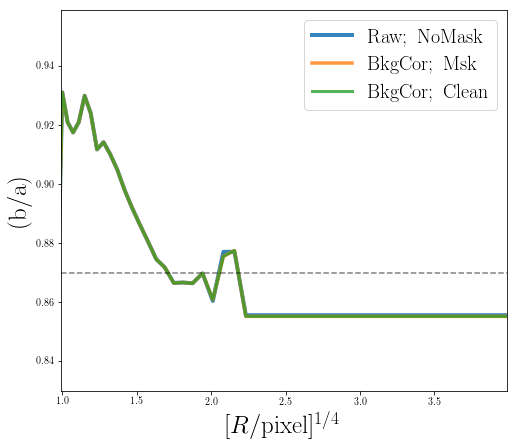

In [316]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         1.0 - obj1_nomsk_iso.eps,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         1.0 - obj1_bgmsk_iso.eps,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         1.0 - obj1_clean_iso.eps,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(0.87, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(0.83, 0.959)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$(\mathrm{b}/\mathrm{a})$', fontsize=25)

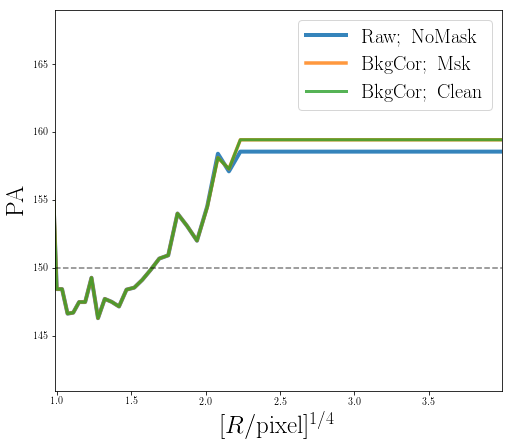

In [317]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(150, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{PA}$', fontsize=25)

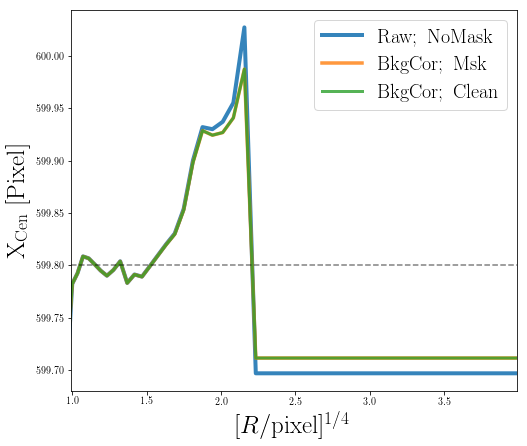

In [318]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.x0,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.x0,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.x0,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(599.80, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
#ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{X_{\mathrm{Cen}}}\ [\mathrm{Pixel}]$', fontsize=25)

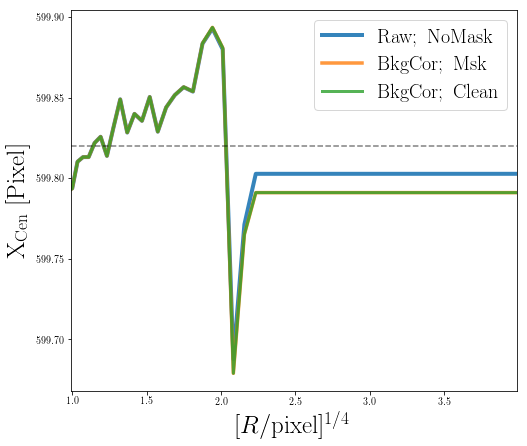

In [319]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.y0,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.y0,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.y0,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(599.82, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
#ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{X_{\mathrm{Cen}}}\ [\mathrm{Pixel}]$', fontsize=25)

In [320]:
obj1_geom_fix = Geometry(599.80, 599.82, 2., 0.13, (150.0 / 180.0 * np.pi))

obj1_nomsk_ellip_fix = Ellipse(gal_img, geometry=obj1_geom_fix)

obj1_bgmsk_ellip_fix = Ellipse((gal_img_msk - bkg_new.back()), geometry=obj1_geom_fix)

obj1_clean_ellip_fix = Ellipse((img_noise_nocen - bkg_new.back()), geometry=obj1_geom_fix)

Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0


In [321]:
obj1_nomsk_iso_fix = obj1_nomsk_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=2, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True, verbose=False)

obj1_bgmsk_iso_fix = obj1_bgmsk_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=2, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True, verbose=False)

obj1_clean_iso_fix = obj1_clean_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=1, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True, verbose=False)

In [322]:
print(-2.5 * np.log10(np.nanmax(obj1_nomsk_iso_fix.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_bgmsk_iso_fix.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_clean_iso_fix.tflux_e)) + 27.0)

print(-2.5 * np.log10(np.nanmax(obj1_nomsk_iso.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_bgmsk_iso.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_clean_iso.tflux_e)) + 27.0)

16.6342630077 17.9415850542 17.7257416633
16.6524690243 17.9464190843 17.7266099063


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


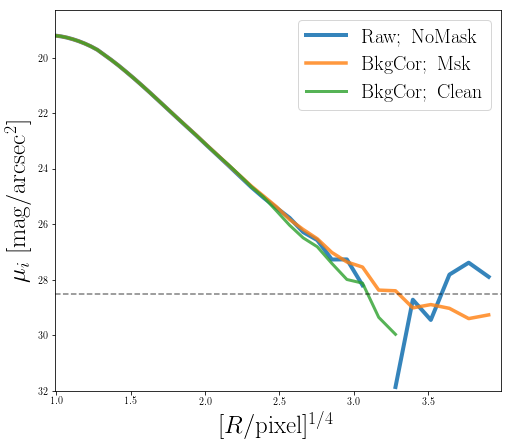

In [323]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso_fix.sma ** 0.25, 
         (-2.5 * np.log10(obj1_nomsk_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso_fix.sma ** 0.25, 
         (-2.5 * np.log10(obj1_bgmsk_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

#----------------------------------------------------------------------------------------#
rsma = obj1_clean_iso_fix.sma ** 0.25
sbp = (-2.5 * np.log10(obj1_clean_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)

rsma = rsma[0: np.max(np.argwhere(np.isfinite(sbp)))]
sbp = sbp[0: np.max(np.argwhere(np.isfinite(sbp)))]

flag_use = np.isfinite(sbp)

rsma_use = rsma[np.isfinite(sbp)]
sbp_use = sbp[np.isfinite(sbp)]
nodes = rsma_use[2:-2]

sbp_intrp = LSQUnivariateSpline(rsma_use, sbp_use, nodes)(rsma)
sbp[~flag_use] = sbp_intrp[~flag_use]
#----------------------------------------------------------------------------------------#

ax1.plot(rsma, sbp,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(28.5, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(31.99, 18.29)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mu_{i}\ [\mathrm{mag}/\mathrm{arcsec}^2]$', fontsize=25)

# TODO List

    - [ ] Identify central object, do not remove from segmentation image
    - [ ] Identify objects within the inner region, do not remove them from the segmentation image
    - [ ] For brighter objects, grow the footprint a little bit 
    - [ ] 